Start: (0.03, 40.00), Goal: (109.80, 10.00)
start_point_in_polygon: 0
goal_point_in_polygon: 0
find_visible_start: [Point(60.00, 60.00), Point(0.00, 60.00), Point(0.00, 0.00), Point(110.00, 0.00), Point(60.00, 20.00)]
find_visible_goal: [Point(110.00, 20.00), Point(60.00, 20.00), Point(0.00, 0.00), Point(110.00, 0.00)]
Closest start point: (-0.00, 40.00)
Closest goal point: (110.00, 10.00)


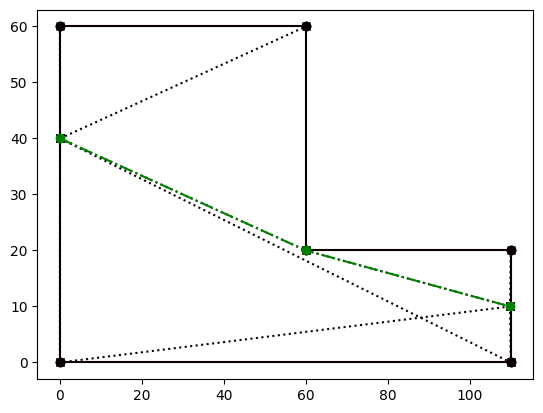

In [59]:
import pyvisgraph as vg
import matplotlib.pyplot as plt
from matplotlib import cm


def plot_vis_graph(ax, graph: vg.Graph):
    for edge in graph.edges:
        ax.plot([edge.p1.x, edge.p2.x], [edge.p1.y, edge.p2.y],
                c=cm.hot(edge.p1.polygon_id/255), ls="solid", marker="o")


def plot_vis_graph_visibile(ax, graph: vg.VisGraph, start: vg.Point):
    for pt in g.find_visible(start):
        ax.plot([start.x, pt.x], [start.y, pt.y], c=cm.hot(
            pt.polygon_id/255), ls="dotted", marker="x")


def plot_vis_graph_path(ax, path: list, params="-ro"):
    x, y = [], []
    for pt in path:
        x.append(pt.x)
        y.append(pt.y)
    ax.plot(x, y, params)


def project_on_polygon_hull(p: vg.Point, g: vg.VisGraph, polygon_id=0, length=0.001):
    """Assumes p is interior to the polygon with polygon_id. Returns the
    closest point c inside the polygon to p, where the distance from c to 
    the intersect point from p to the edge of the polygon is length."""
    polygon_edges = g.graph.polygons[polygon_id]
    close_point = None
    close_edge = None
    close_dist = None
    # Finds point closest to p, but on a edge of the polygon.
    # Solution from http://stackoverflow.com/a/6177788/4896361
    for i, e in enumerate(polygon_edges):
        num = ((p.x-e.p1.x)*(e.p2.x-e.p1.x) + (p.y-e.p1.y)*(e.p2.y-e.p1.y))
        denom = ((e.p2.x - e.p1.x)**2 + (e.p2.y - e.p1.y)**2)
        u = num/denom
        pu = vg.Point(e.p1.x + u*(e.p2.x - e.p1.x),
                      e.p1.y + u*(e.p2.y - e.p1.y))
        pc = pu
        if u < 0:
            pc = e.p1
        elif u > 1:
            pc = e.p2
        d = vg.visible_vertices.edge_distance(p, pc)
        if i == 0 or d < close_dist:
            close_dist = d
            close_point = pc
            close_edge = e

    # Extend the newly found point so it is outside the polygon by `length`.
    if close_point in close_edge:
        c = close_edge.p1 if close_point == close_edge.p1 else close_edge.p2
        edges = list(g.graph[c])
        v1 = vg.visible_vertices.unit_vector(c, edges[0].get_adjacent(c))
        v2 = vg.visible_vertices.unit_vector(c, edges[1].get_adjacent(c))
        vsum = vg.visible_vertices.unit_vector(
            vg.Point(0, 0), vg.Point(v1.x + v2.x, v1.y + v2.y))
        close1 = vg.Point(c.x + (vsum.x * length), c.y + (vsum.y * length))
        close2 = vg.Point(c.x - (vsum.x * length), c.y - (vsum.y * length))
        if vg.visible_vertices.point_in_polygon(close1, g.graph) == -1:
            return close1
        return close2
    else:
        v = vg.visible_vertices.unit_vector(p, close_point)
        if v.x == 0 and v.y == 0:
            # print("calculate normal vector: (-dy, dx) or (dy, -dx)")
            v.x = (close_edge.p1.y - close_edge.p2.y)
            v.y = -(close_edge.p1.x - close_edge.p2.x)
        
        r = vg.Point(close_point.x + v.x*length, close_point.y + v.y*length)
        if g.point_in_polygon(r) != polygon_id:
            r = vg.Point(close_point.x - v.x*length, close_point.y - v.y*length)                

        return r


def build_visgraph(polys: list):
    g = vg.VisGraph()
    # g.build(polys, workers=8, status=True)
    # Manual build, assuming each polygon vertices are in-order (ccw or cw).
    g.graph = vg.Graph(polys)
    g.visgraph = vg.Graph([])

    for edge in g.graph.edges:
        g.visgraph.add_edge(edge)

    return g


polys = [[vg.Point(0, 0),
          vg.Point(110, 0),
          vg.Point(110, 20),
          vg.Point(60, 20),
          vg.Point(60, 60),
          vg.Point(0, 60)]]

g = build_visgraph(polys)

start = project_on_polygon_hull(vg.Point(3, 40), g, 0, 0.01)
goal = project_on_polygon_hull(vg.Point(110, 10), g, 0, 0.01)

plot_vis_graph(plt.gca(), g.graph)
plot_vis_graph_visibile(plt.gca(), g, start)
plot_vis_graph_visibile(plt.gca(), g, goal)

shortest = g.shortest_path(start, goal)
plot_vis_graph_path(plt.gca(), shortest, "-.go")

print(f"Start: {start}, Goal: {goal}")

# poly_id otherwise -1
print(f"start_point_in_polygon: {g.point_in_polygon(start)}")
# poly_id otherwise -1
print(f"goal_point_in_polygon: {g.point_in_polygon(goal)}")
print(f"find_visible_start: {g.find_visible(start)}")
print(f"find_visible_goal: {g.find_visible(goal)}")
print(f"Closest start point: {g.closest_point(start, 0, length=0.001)}")
print(f"Closest goal point: {g.closest_point(goal, 0, length=0.001)}")

# print(g.graph.polygons.items())
# vg.visible_vertices.polygon_crossing(start, g.graph.edges)
# vg.visible_vertices.visible_vertices(polys[0][1], g.graph, origin=None, destination=None, scan='full')
# vg.visible_vertices.polygon_crossing(goal, g.graph.edges)
